In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import itertools

import numpy as np

import torch
from torch import nn


device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Session 2 – NLP Models and Training Basics (RNN)
  
In this notebook, we will dive into fundamental sequence models such as **RNNs** and **LSTMs**. We’ll also cover basic neural embeddings, training objectives, and see how to implement and train a **simple text generator** using an LSTM.


## Table of Contents

1. [Introduction and Overview](#introduction)
2. [Recurrent Neural Networks (RNNs)](#rnns)
   - [The RNN Cell](#rnn-cell)
   - [Vanishing and Exploding Gradients](#vanishing)
3. [Long Short-Term Memory (LSTM)](#lstm)
   - [Key Intuition Behind LSTM Gates](#lstm-gates)
4. [Embeddings](#embeddings)
5. [Basic Training Objectives in Language Modeling](#training-objectives)
   - [Next Token Prediction](#next-token-pred)
   - [Perplexity](#perplexity)
6. [Implementing a Simple LSTM Text Generator in PyTorch](#implementation)
   - [Data Preparation](#data-prep)
   - [Model Definition](#model-def)
   - [Training Loop](#training-loop)
   - [Generating Text](#generate-text)
7. [Conclusion](#conclusion)

Each section will be followed by one or more **Exercises** to help you practice.

# <a id="overview"></a>1. Overview and Setup

This tutorial assumes you have:

- **Basic Python** knowledge.
- A local or cloud environment (e.g., Jupyter, Colab) with **PyTorch** installed.
  - If needed, install PyTorch via `pip install torch` or follow instructions at [pytorch.org](https://pytorch.org/get-started/locally/).

No prior reading of other sessions is required; we’ll present all the essentials here.

### Quick Setup Check
```python
import torch
print("PyTorch version:", torch.__version__)
```

Ensure you see a version number (e.g., `2.0.0` or similar) printed. If you get an error, please install or update PyTorch before continuing.

- We’ll focus on **RNNs** and **LSTMs**.  
- We’ll learn **why** they are powerful for sequential data.  
- We’ll cover **basic training objectives** (like next-token prediction) for language modeling.  
- Finally, we’ll implement a small **LSTM-based text generator**.

**By the end of this session**, you should be able to:
1. Understand how an RNN cell and LSTM cell process sequential data.  
2. Implement an **LSTM** in a deep learning framework (here, PyTorch).  
3. Train and evaluate a **text-generation** model.  

In [3]:
import torch
print("PyTorch version:", torch.__version__)

PyTorch version: 2.6.0


# 2. Recurrent Neural Networks (RNNs)<a id="rnns"></a>

Recurrent Neural Networks are designed to handle **sequential data** by maintaining a hidden state that captures information about previous time steps. 

## Key Idea
At each time step $t$:
1. The RNN takes an input $x_t$ and the hidden state from the previous time step $h_{t-1}$.
2. It produces a new hidden state $h_t$.

Mathematically, a very **basic** RNN can be written as:
$$
\begin{aligned}
h_t &= \tanh(W_{hh} h_{t-1} + W_{xh} x_t + b_h) \\
y_t &= W_{hy} h_t + b_y
\end{aligned}
$$

- $h_t$ is the updated hidden state.
- $y_t$ is the output at time step $t$ (used for tasks like classification or next-token prediction).
- $W_{hh}, W_{xh}, W_{hy}$ are learned weight matrices.

**Rearrangement of Terms**

Notice that the term $W_{hh} h_{t-1} + W_{xh} x_t$ uses two matrix multiplications and an addition.
Unless compiled, these two multiplications will be performed sequentially.
We can gain a slight improvement if we concatenate $h$ and $x$, and use a single matrix multiplication by a larger weight matrix:

$$
\begin{aligned}
h_t &= \tanh(W_h H_t + b_h) \\
y_t &= W_{hy} h_t + b_y
\end{aligned}
$$

- $H_t = [h_{t-1}||x_t]$ is the concatenation of $h$ and $x$
- $W_{h} = [W_{hh}||W_{xh}]$ is the cconcatenaation of $W_{hh}, W_{xh}$


<img src="img_src/RNNs.svg"/>


## <a id="rnn-cell"></a>The RNN Cell

The **RNN cell** is the fundamental computational unit. At time step $t$:
1. **Input**: current token (often embedded) + previous hidden state.
2. **Output**: updated hidden state + optional output vector.

If you unroll this cell over time for $T$ steps, you get a **computation graph** that looks like a chain, where each link is an RNN cell.

<img src="img_src/RNN-folded.svg"/>
<img src="img_src/RNN-unfolded.svg"/>

### Exercise: Implement a Toy RNN Cell
**Goal**:  
1. Write a Python function that computes a single time-step of an RNN.  
1. Use NumPy or PyTorch (in NumPy style) to do the matrix multiplication and a `tanh` activation.  
1. Test it on a small input (e.g., input dimension of 5, hidden dimension of 3).

*(Keep it simple—focus on the concept, not a full RNN unrolled over time.)*  

In [4]:
import torch

def rnn_step(x_t, h_prev, Wxh, Whh, bh):
    """Simple RNN step

    Args:
        x_t: shape (batch_size, input_dim)
        h_prev: shape (batch_size, hidden_dim)
        Wxh: shape (input_dim, hidden_dim)
        Whh: shape (hidden_dim, hidden_dim)
        bh: shape (hidden_dim,)
    Returns:
        h_t: shape (batch_size, hidden_dim) 
    """
    weighted_h = h_prev @ Whh  # shape: (batch_size, hidden_dim)
    weighted_x = x_t @ Wxh  # shape: (batch_size, hidden_dim)
    linear_hx = weighted_h + weighted_x + bh
    nonlinear_hx = torch.tanh(linear_hx)
    return nonlinear_hx

# Tests -- we only consider shapes here
N = (1, 2, 5)  # Batch sizes
hidden_dims = (1, 2, 5)  # Hidden sizes
input_dims = (1, 2, 5)  # Input sizes

failed_cases = []
for batch_size, hdim, xdim in itertools.product(N, hidden_dims, input_dims):
    x = torch.ones(batch_size, xdim)
    h = torch.zeros(batch_size, hdim)
    Wxh = torch.ones(xdim, hdim)
    Whh = torch.ones(hdim, hdim)
    bh = torch.zeros(hdim)
    expect_shape = (batch_size, hdim)
    with torch.no_grad():
        h_next = rnn_step(x, h, Wxh, Whh, bh)
    if h_next.shape != expect_shape:
        print('x', end='')
        failed_cases.append((h_next.shape, expect_shape))
    else:
        print('.', end='')
print()
for got, expected in failed_cases:
    print(f"{expected} vs. {got}")

...........................


## <a id="vanishing"></a>Vanishing and Exploding Gradients

**Problem**: Simple RNNs often struggle with **long-term dependencies** due to **vanishing** or **exploding gradients**. That means:
- When sequences are long, the gradient that flows backward through time either becomes extremely small (**vanishes**) or extremely large (**explodes**).
- This makes training unstable or ineffective for capturing long-range context.

**Solution**: Specialized RNN variants like **LSTM** or **GRU** mitigate these issues by incorporating gating mechanisms.

### Research Note: let's invent a GRU (Gated Recurrent Unit)

**RNN** : $h_t = \phi(W_hh_{t-1} + W_xx_{t})$

* **Problem:** To compute the gradient of $h_1$ (or any early token), we need to multiply the gradients by small values in $W_h$, thus **vanishing** it.
* **Solution:** Intelligently choose the previous memory: $h_t = \phi(W_hh_{t-1} + W_xx_{t})$ or $h_t = h_{t-1}$

**RNN with no vanishing** : $h_t = \alpha\odot\hat{h}_t + (1-\alpha)\odot h_{t-1}$, where $\hat{h}_t=\phi(W_hh_{t-1} + W_xx_{t})$

* **Problem:** To compute the gradient of $h_1$ (or any early token), we need to multiply the gradients by large values in $W_h$, thus **exploding** it.
* **Solution:** Intelligently choose to set the previous memory to zero before multiplying it by the weights: $h_t = \phi(W_hh_{t-1} + W_xx_{t})$ or $h_t = \phi(W_xx_{t})$

**RNN with no explosion** : $h_t = \phi(W_h(\beta \odot h_{t-1}) + W_xx_{t})$

* **Problem:** How do we decide on the values of $\alpha$ and $\beta$?
* **Solution:** Don't! Let the data decide (learning)

$$
\begin{aligned}
h_t &= \overbrace{\alpha\odot\underbrace{\phi\left(W_h(\beta \odot h_{t-1}) + W_xx_{t}\right)}_{\text{no explosion}} + (1-\alpha)\odot h_{t-1}}^\text{no vanishing} \\
\text{where}\\
\alpha &= \sigma\left(Ah_{t-1} + Bx_t\right) &&\text{Memory Update Gate}\\
\beta &= \sigma\left(Ch_{t-1} + Dx_t\right) &&\text{Memory Reset Gate}
\end{aligned}
$$

**Congratulations**, you have just invented a **Gated Recurrent Unit** (GRU)!

*An earlier version of a gated recurrent network is [LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory), which follows very similar logic for preserving the long-term context infromation.*

| Network | Complexity | Long-Term Relationship | Gradient Issues |
|---------|--------------|------|----|
| RNN (tanh) | (++) | None | (-) |
| GRU | (+) | (+)<br/>Single state | (++) |
| LSTM | (--) | (++)<br/>Separate state for long and short terms | (++) |

### Exercise: Compare RNN and GRU Outputs (or LSTM if you prefer)
1. Create a synthetic sequence of length 20.  
2. Feed it into a small **Vanilla RNN** and a small **GRU** (in PyTorch).  
3. Compare the final hidden states after feeding all time steps. Are they similar? If you vary the length from 20 to 50 to 100, how do the hidden states change?

*Hint*: This is a conceptual experiment. You can use random inputs, then measure how the hidden states drift over longer sequences. 

*Hint*: You can use the utilities in the `utils.py` file to generate simple synthetic sequences (`generate_synthetic_sequences`).

*Hint*: You don't have to train the network, but if you want to you can use `utils.py` (`train_recurrent`)

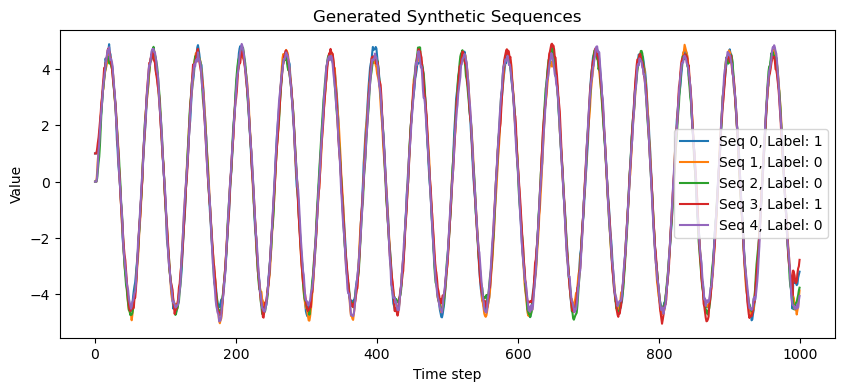

In [5]:
import matplotlib.pyplot as plt

from utils import generate_synthetic_sequences

sequence_length = 1000

seqs, labels = generate_synthetic_sequences(120, min_length=sequence_length, max_length=sequence_length)
seqs = np.array(seqs)

plt.figure(figsize=(10, 4))
for i in range(5):
    plt.plot(seqs[i], label=f'Seq {i}, Label: {labels[i]}')
plt.legend()
plt.title("Generated Synthetic Sequences")
plt.xlabel("Time step")
plt.ylabel("Value")
plt.show()

In [6]:
# Make train and test sample split
num_train = 100

seqs_torch = torch.tensor(seqs, dtype=torch.float, device=device)
labels_torch = torch.tensor(labels, dtype=torch.long, device=device)

seqs_train = seqs_torch[:num_train]
labs_train = labels_torch[:num_train]

seqs_valid = seqs_torch[num_train:]
labs_valid = labels_torch[num_train:]

print(labs_train.sum()/len(labs_train), labs_valid.sum()/len(labs_valid))

tensor(0.5100) tensor(0.4000)


In [7]:
class _BaseRecurrent(nn.Module):
    def __init__(self, data_dim, state_dim):
        super().__init__()
        # Save arguments -- just in case
        self.data_dim = data_dim
        self.state_dim = state_dim

        # Placeholder for the hidden state
        self.hidden_state = None

    def reset_hidden_state(self):
        self.hidden_state = None
        return self


class ClassifierHead(nn.Sequential):
    r"""Head to convert hidden layer to some class"""
    def __init__(self, hidden_dim, num_classes, num_layers=1):
        super().__init__()
        for layer in range(num_layers-1):
            self.append(nn.Linear(hidden_dim, hidden_dim))
            self.append(nn.ReLU())
        self.append(nn.Linear(hidden_dim, num_classes))


class RNN(_BaseRecurrent):
    def __init__(self, data_dim, state_dim):
        super().__init__(data_dim, state_dim)

        # Define parameters to train
        self.input_linear = nn.Linear(  # Takes [x||h_prev] and produces h_next
            in_features=self.data_dim + self.state_dim,
            out_features=self.state_dim,
            bias=True)
        self.output_linear = nn.Linear(  # Takes h_next and produces y
            in_features=self.state_dim,
            out_features=self.data_dim,
            bias=True)
        self.tanh = nn.Tanh()

    def forward(self, x):
        # Concatenate x and hidden_state
        if self.hidden_state is None:
            self.hidden_state = torch.zeros(x.shape[0], self.state_dim, device=x.device, dtype=x.dtype)
        xh = torch.hstack([x, self.hidden_state])

        # Compute new hidden state
        xh = self.input_linear(xh)
        self.hidden_state = self.tanh(xh)

        # Compute output
        y = self.output_linear(self.hidden_state)
        return y

class GRU(_BaseRecurrent):
    def __init__(self, data_dim, state_dim):
        super().__init__(data_dim, state_dim)

        # Define parameters to train (input and output)
        self.input_linear = nn.Linear(  # Takes [x||h_prev] and produces h_next
            in_features=self.data_dim + self.state_dim,
            out_features=self.state_dim,
            bias=True)
        self.output_linear = nn.Linear(  # Takes h_next and produces y
            in_features=self.state_dim,
            out_features=self.data_dim,
            bias=True)
        self.tanh = nn.Tanh()
        # Define parameters to train (gates)
        self.update_linear = nn.Linear(
            in_features=self.data_dim + self.state_dim,
            out_features=self.state_dim,
            bias=True)
        self.update_sigmoid = nn.Sigmoid()
        self.reset_linear = nn.Linear(
            in_features=self.data_dim + self.state_dim,
            out_features=self.state_dim,
            bias=True)
        self.reset_sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Concatenate x and hidden_state
        if self.hidden_state is None:
            self.hidden_state = torch.zeros(x.shape[0], self.state_dim, device=x.device, dtype=x.dtype)
        xh = torch.hstack([x, self.hidden_state])

        # Compute gate resuls
        update = self.update_sigmoid(self.update_linear(xh))
        reset = self.reset_sigmoid(self.reset_linear(xh))

        # Create gated hidden state and concatenate it with the input
        gated_hidden = reset * self.hidden_state
        xh_gated = torch.hstack([x, gated_hidden])

        # Compute new hidden state by gating it through "update"
        self.hidden_state = update * xh_gated + (1.0 - update) * self.hidden_state

        # Compute output
        y = self.output_linear(self.hidden_state)
        return y

In [12]:
from utils import train_step_recurrent, valid_step_recurrent

rnn_generator = RNN(data_dim=1, state_dim=4).to(device)
rnn_classifier = ClassifierHead(hidden_dim=4, num_classes=2, num_layers=1).to(device)

EPOCHS = 100
lr = 1.0e-1

optimizer = torch.optim.AdamW(
    list(rnn_generator.parameters()) + list(rnn_classifier.parameters()),
    lr=lr,
)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

generation_criterion = nn.MSELoss()
classification_criterion = nn.CrossEntropyLoss()

generation_weight = 1.0
classification_weight = 3.0

# We will load the whole batch in the memory -- only 100 samples
loss_history = [[], []]
accuracy_history = [[], []]

for epoch in range(EPOCHS):
    losses, accuracy = train_step_recurrent(rnn_generator, rnn_classifier,
                                            (seqs_train, labs_train),
                                            generation_criterion,
                                            classification_criterion,
                                            optimizer,
                                            weight_gen=10.0,
                                            weight_class=1.0,)
    lr_scheduler.step()
    loss_history[0].append(losses[0])
    accuracy_history[0].append(accuracy)

    losses, accuracy = valid_step_recurrent(rnn_generator, rnn_classifier,
                                            (seqs_valid, labs_valid),
                                            generation_criterion,
                                            classification_criterion,
                                            weight_gen=10.0,
                                            weight_class=1.0,)
    loss_history[1].append(losses[0])
    accuracy_history[1].append(accuracy)

    if (epoch+1) % 10 == 0:
        print(loss_history[1][-1], accuracy_history[1][-1])


RuntimeError: The size of tensor a (4) must match the size of tensor b (5) at non-singleton dimension 1

torch.Size([2, 1000])


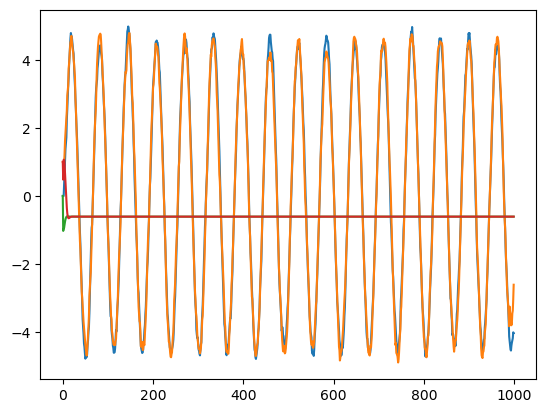

In [11]:
seq_sample = seqs_valid[:2]
seq_generated = [seq_sample[:, 0].reshape(-1, 1)]

rnn_generator.reset_hidden_state()
with torch.no_grad():
    for idx in range(len(seq_sample[0])-1):
        next_token = rnn_generator(seq_generated[-1].reshape(-1, 1))
        # print('DEBUG', seq_generated[-1].shape, next_token.shape)
        seq_generated.append(next_token)

seq_generated = torch.hstack(seq_generated)

print(seq_sample.shape)
seq_generated.shape
        
plt.plot(seq_sample[0])
plt.plot(seq_sample[1])
plt.plot(seq_generated[0])
plt.plot(seq_generated[1])

In [ ]:
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.plot(seqs[i], label=f'Seq {i}, Label: {labels[i]}')
plt.legend()
plt.title("Generated Synthetic Sequences")
plt.xlabel("Time step")
plt.ylabel("Value")
plt.show()